In [1]:
import pandas as pd
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

#  Читаем данные из файла, делает табличную визуализацию

In [3]:
data=pd.read_csv("WAG_C_M.csv",sep=";",index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
data.head(2)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1


In [5]:
print data.shape

(284, 1)


# 1. Построим график временного ряда:

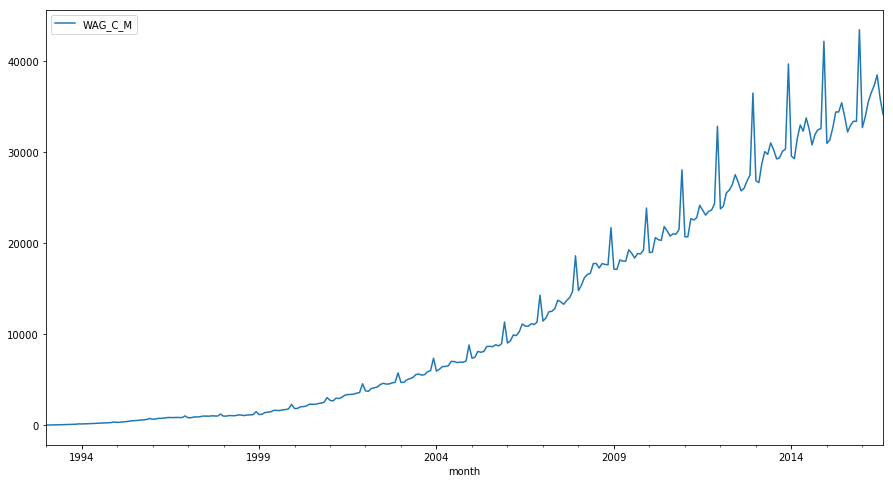

In [6]:
plt.figure(figsize(15,8))
data.plot()

### При визуальном анализе видим следующее:
 1) Выделяется растущий тренд
 2) Четко выделяются сезонные колебания с периодом 12 месяцев
 3) Визуально не наблюдаются циклы
 4) Предположительно, случайная компонента ("щум", "ошибка") в данном датасете мала

In [7]:
from scipy import stats
import statsmodels.api as sm

C:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 2. Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


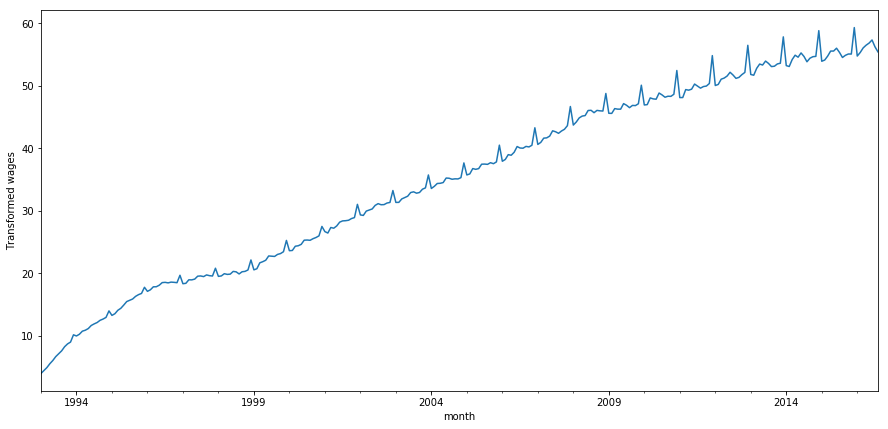

In [8]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

# 3. Выбираем порядок дифференцирования

Критерий Дики-Фуллера: p=0.696899


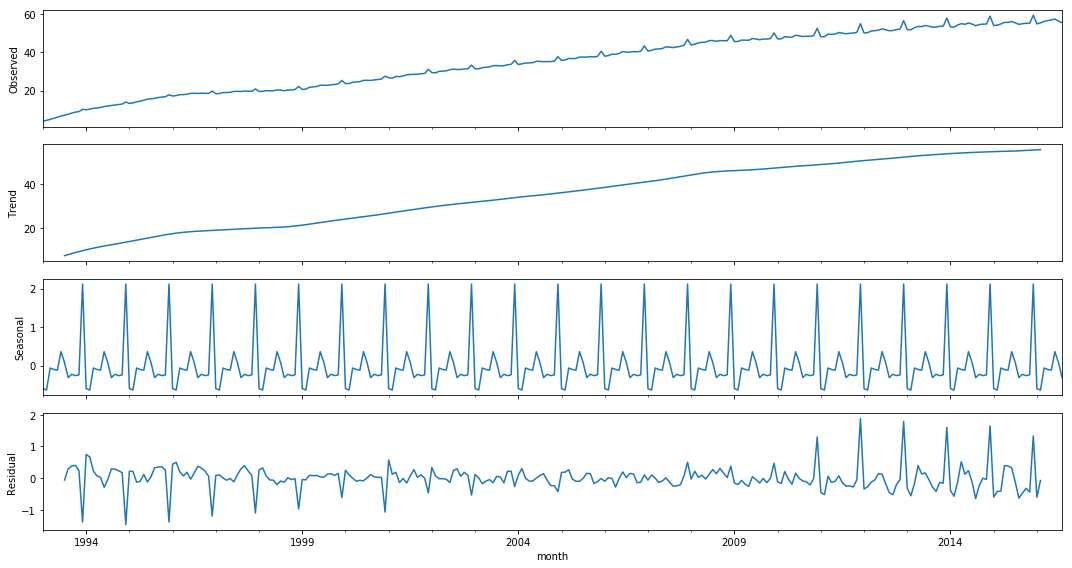

In [9]:
plt.figure(figsize(15,8))
(sm.tsa.seasonal_decompose(data.WAG_C_M_box)).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

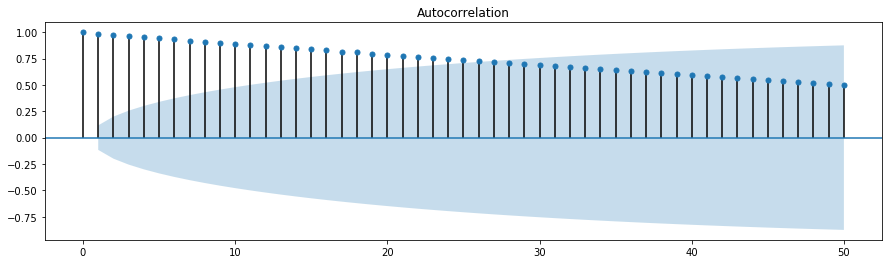

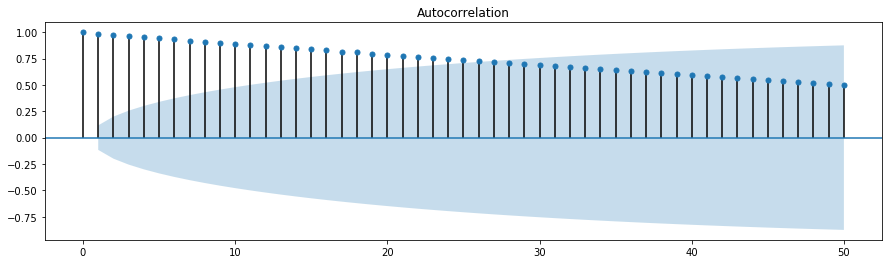

In [10]:
import statsmodels.api as sm
plt.figure(figsize(15,4))
sm.graphics.tsa.plot_acf(((data.WAG_C_M_box).iloc[0:]).squeeze(), lags=50)

In [11]:
data["daily_diff1"] = 0.0
data["daily_diff12"] = 0.0
data["daily_diff1"] = data.WAG_C_M_box - data.WAG_C_M_box.shift(1)
data["daily_diff12"] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
data["daily_diff112"] = data.daily_diff1 - data.daily_diff1.shift(12)

In [12]:
data.head(14)

,WAG_C_M,WAG_C_M_box,daily_diff1,daily_diff12,daily_diff112
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,NaN
1993-02-01,19.1,4.458758,0.468365,NaN,NaN
1993-03-01,23.6,4.931635,0.472877,NaN,NaN
1993-04-01,30.6,5.549430,0.617795,NaN,NaN
1993-05-01,37.5,6.063406,0.513976,NaN,NaN
1993-06-01,47.4,6.690719,0.627313,NaN,NaN
1993-07-01,56.0,7.161310,0.470592,NaN,NaN
1993-08-01,65.4,7.618224,0.456914,NaN,NaN
1993-09-01,80.9,8.275619,0.657395,NaN,NaN


In [13]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data.daily_diff1).iloc[1:])[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data.daily_diff12).iloc[12:])[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data.daily_diff112).iloc[13:])[1])


Критерий Дики-Фуллера: p=0.014396
Критерий Дики-Фуллера: p=0.014697
Критерий Дики-Фуллера: p=0.000000


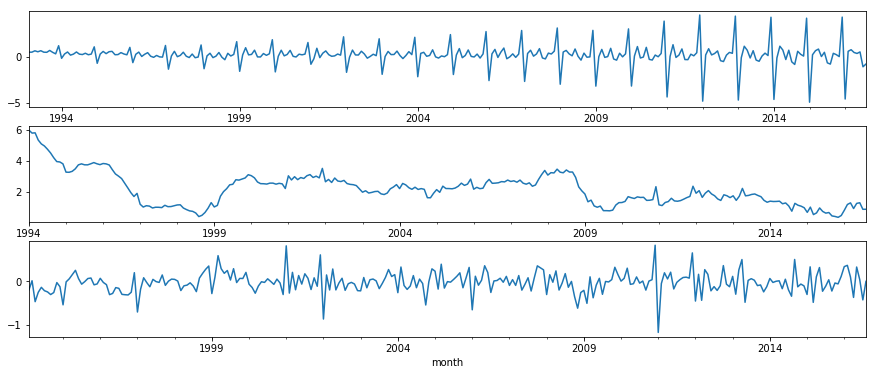

In [14]:
plt.figure(figsize(15,6))
pyplot.subplot(3, 1, 1)
((data.daily_diff1).iloc[1:]).plot()
pyplot.subplot(3, 1, 2)
((data.daily_diff12).iloc[12:]).plot()
pyplot.subplot(3, 1, 3)
((data.daily_diff112).iloc[13:]).plot()

In [15]:
# Model parameters:
d=1
D=1

# 4. Выбор начальных приближений для p,q,P,Q

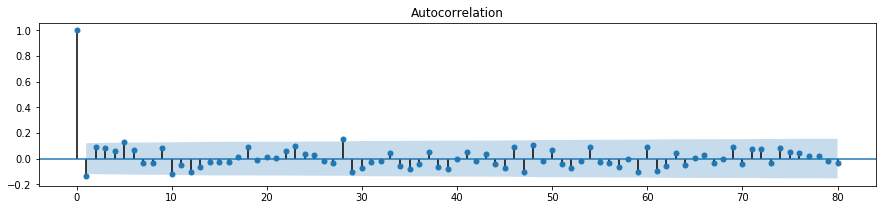

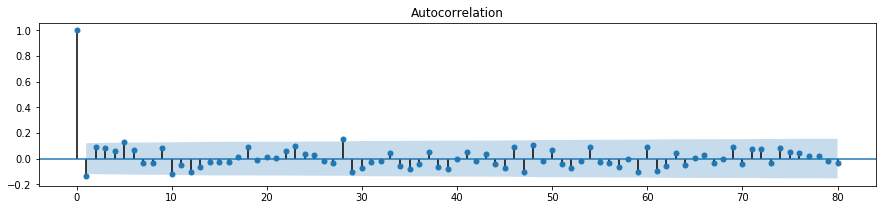

In [16]:
import statsmodels.api as sm
plt.figure(figsize(15,3))
sm.graphics.tsa.plot_acf(((data.daily_diff112).iloc[13:]).squeeze(), lags=80)

In [17]:
# Model parameters:
Q=0
q=1

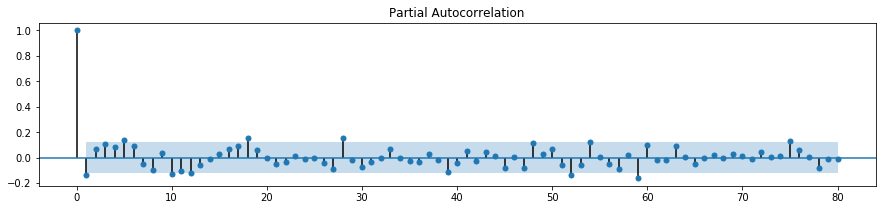

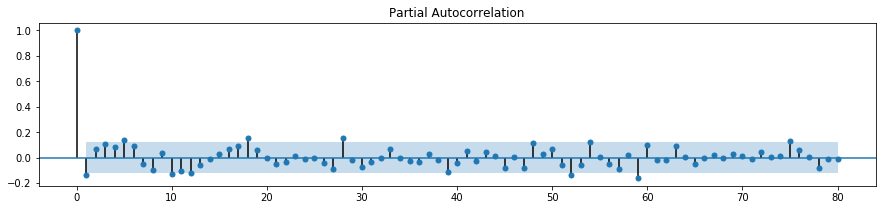

In [18]:
sm.graphics.tsa.plot_pacf(((data.daily_diff112).iloc[13:]).squeeze(), lags=80)

In [19]:
# Model parameters:
P=1
p=1

Для модели используем следующий набор параметров:
d=1
D=1
Q=0
q=1
P=1
p=1

# 5. Обучение и сравнение моделей-кандидатов, выбор победителя


In [36]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2) 
D=1
Qs = range(0, 1) 

In [37]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [38]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 1.52 s


In [39]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021911
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832


In [40]:
# Final model parameters
d=1 
D=1 
p=1
q=0 
P=1
Q=0 

In [41]:
model=sm.tsa.statespace.SARIMAX((data.WAG_C_M_box).iloc[0:], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, 12)).fit(disp=-1)
aic = model.aic
print aic

0.340520900823


In [42]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Fri, 15 Sep 2017   AIC                              0.341
Time:                                    20:49:06   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

# 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


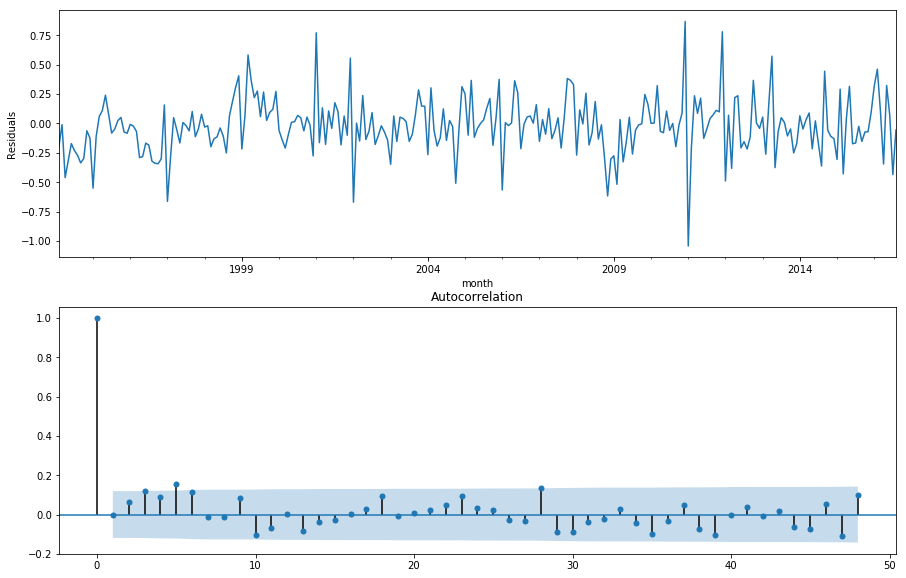

In [32]:
plt.figure(figsize(15,10))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

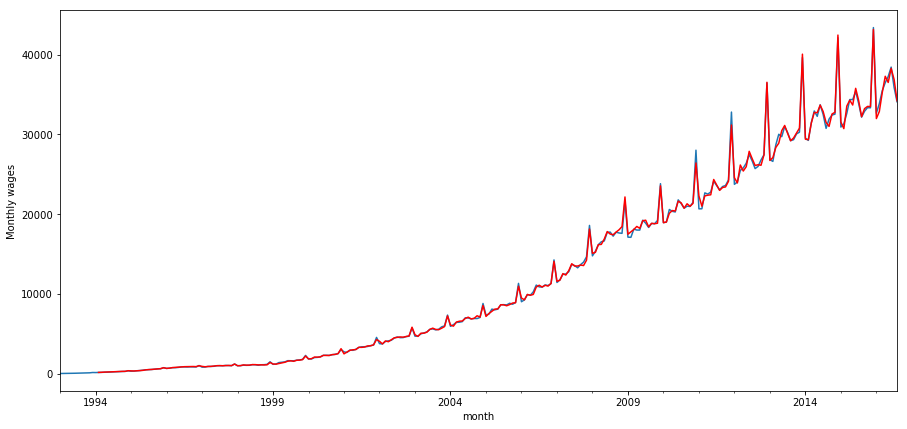

In [33]:
data['model'] = invboxcox(model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Monthly wages')
pylab.show()

In [34]:
#print data.iloc[270:]

# 7. Прогнозирование с помощью финальной модели.

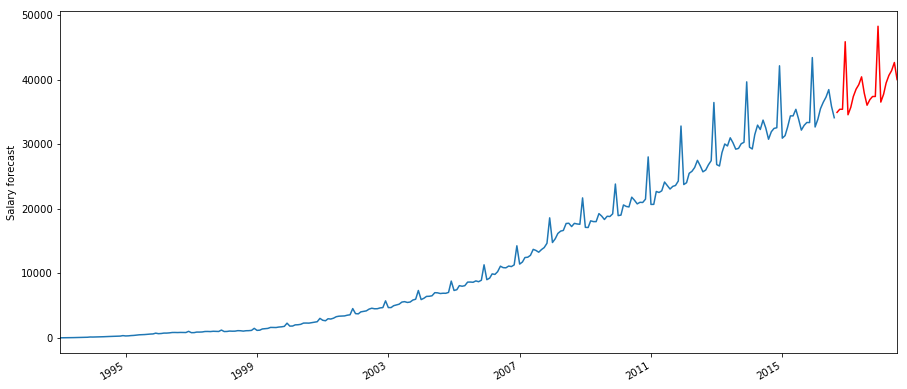

In [35]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(model.predict(start=284, end=316), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary forecast')
pylab.show()